In [1]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

In [2]:
lags = 12
batch_size = 256
epoch = 100

dataloader = torch.utils.data.DataLoader(
    dataset=utils.TrafficDataset(lags),
    batch_size=batch_size,
    drop_last=True,
    generator=torch.Generator(device=device),
    shuffle=False,
)
batch = len(dataloader)

model = utils.SATT()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

progress = []

with tqdm(total=epoch * batch) as bar:
    for e in range(epoch):
        for i, (x, t) in enumerate(dataloader):
            bar.set_description(f"({e + 1:02}/{epoch}) | ({i + 1:02}/{batch})")
            y = model.forward(x)
            loss = criterion(y, t.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress.append(loss.item())
            bar.update()
            bar.set_postfix(loss=f"{loss.item():0.6}")


(100/100) | (30/30): 100%|██████████| 3000/3000 [00:30<00:00, 97.84it/s, loss=0.003128]  


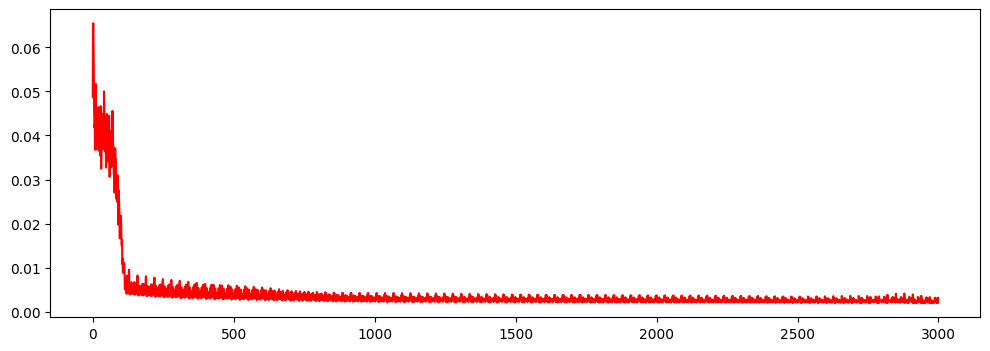

In [3]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(progress, 'r')
plt.show()
plt.close()

In [4]:
tone.utils.learning.save_pickle(model, 'models/att.pt')

In [5]:
pts = glob.glob("models/*.pt")
models = {}
for pt in pts:
    model = tone.utils.learning.load_pickle(pt)
    name = type(model).__name__
    models[name] = model

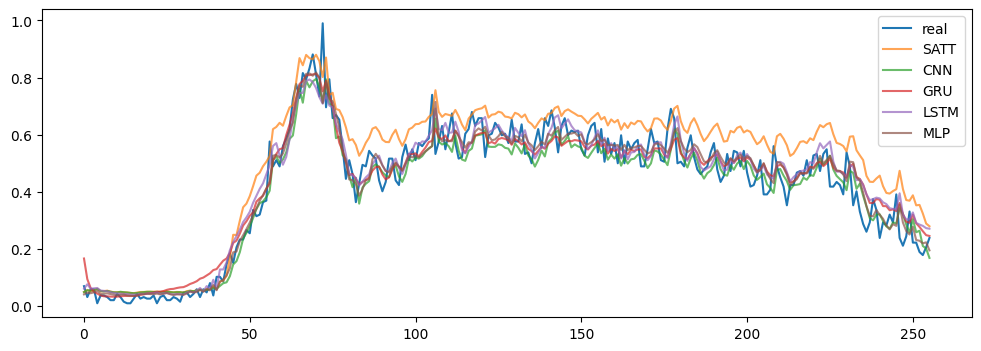

In [6]:
dataloader = torch.utils.data.DataLoader(
    dataset=utils.TrafficDataset(lags, train=False, len=500),
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    generator=torch.Generator(device=device),
)

real = []
for model in models.values():
    model.pred = []

for x, t in dataloader:
    real.append(t)
    for model in models.values():
        y = model.forward(x)
        model.pred.append(y)


real = torch.cat(real).detach().cpu()
for model in models.values():
    model.pred = torch.cat(model.pred).detach().cpu()

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(real, label='real')
for model in models.values():
    ax.plot(model.pred, alpha=0.7, label=type(model).__name__)

plt.legend()
plt.show()
plt.close()

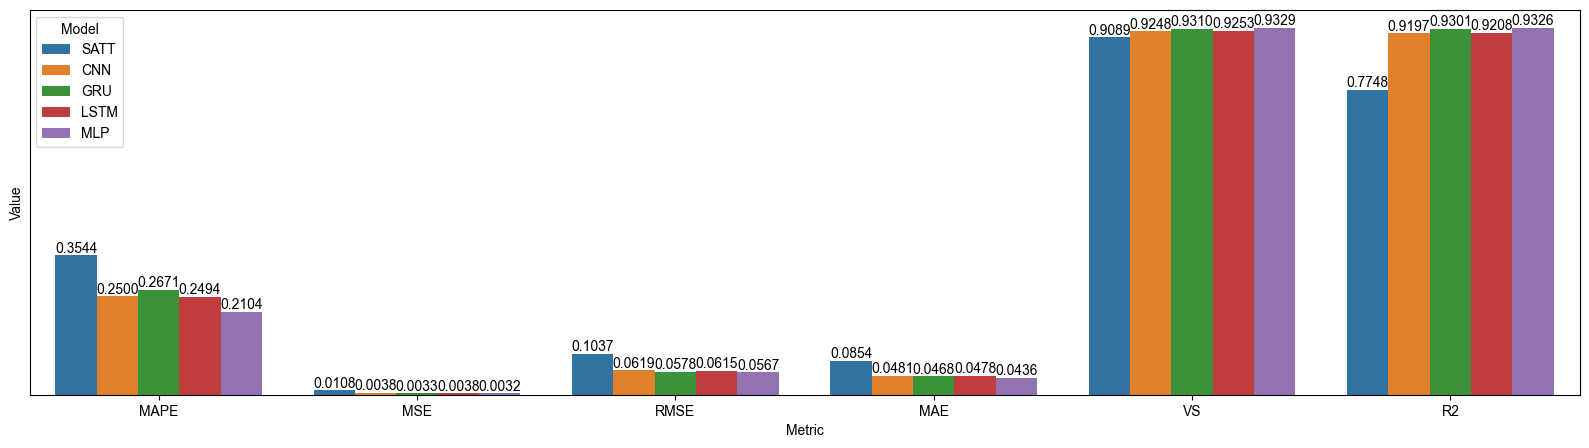

,Metric,SATT,CNN,GRU,LSTM,MLP
0,MAPE,0.354449,0.249971,0.267133,0.249445,0.210431
1,MSE,0.010759,0.003835,0.003341,0.003783,0.003219
2,RMSE,0.103728,0.061930,0.057798,0.061503,0.056739
3,MAE,0.085358,0.048063,0.046785,0.047795,0.043626
4,VS,0.908939,0.924805,0.930985,0.925299,0.932928
5,R2,0.774782,0.919719,0.930075,0.920821,0.932613


In [7]:
df = pd.DataFrame()
data = []

for name, model in models.items():
    m = tone.utils.learning.metrics(real, model.pred)
    df['Metric'] = [key.upper() for key in m.keys()]
    df[name.upper()] = m.values()

    for key, value in m.items():
        data.append([name, key.upper(), value])

data = pd.DataFrame(data, columns=['Model', 'Metric', 'Value'])

fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(data, x='Metric', y='Value', hue='Model', ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')
ax.set_yticks([])
sns.set_style('darkgrid')
plt.show()

df